In [3]:
import os

# 指定目录路径
dir_path = 'data/sat1'

# 获取目录中的文件列表
file_list = os.listdir(dir_path)

# 打印文件列表
print(file_list)

['147_2025031706171299310.csv', '148_2025031706213197341.csv', '154_2025031706080334799.csv', '155_2025031706125033275.csv', '165_2025031706342776216.csv', '166_2025031706383157602.csv', '167_2025031706253370823.csv', '168_2025031706301084560.csv', '5_2025031706435044765.csv', '64_2025031707000877493.csv', '65_2025031707050544724.csv', '8_2025031706482963915.csv']


In [4]:
import pandas as pd
import os

# 指定目录路径
dir_path = 'data/sat1'

# 加载目录中的CSV文件
csv_files = [f for f in file_list if f.endswith('.csv')]
dataframes = {}

for file in csv_files:
    file_path = os.path.join(dir_path, file)
    dataframes[file] = pd.read_csv(file_path)
    
# 打印已加载的CSV文件
print(f"已加载 {len(dataframes)} 个CSV文件")

已加载 12 个CSV文件


In [5]:
import pandas as pd
from datetime import datetime

# 处理每个CSV数据框，设置时间索引
for file, df in dataframes.items():
    # 添加列名（因为原始数据无表头）
    df.columns = ['timestamp', 'value']
    
    # 将时间戳列转换为datetime类型并设置为索引
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # 更新dataframes字典
    dataframes[file] = df

# 打印第一个dataframe的前几行作为示例
if dataframes:
    first_file = list(dataframes.keys())[0]
    print(f"{first_file} 的前5行:")
    print(dataframes[first_file].head())

147_2025031706171299310.csv 的前5行:
                         value
timestamp                     
2024-01-01 00:07:36.286     20
2024-01-01 00:07:50.786     20
2024-01-01 00:08:05.786     20
2024-01-01 00:08:20.285     20
2024-01-01 00:08:35.285     20


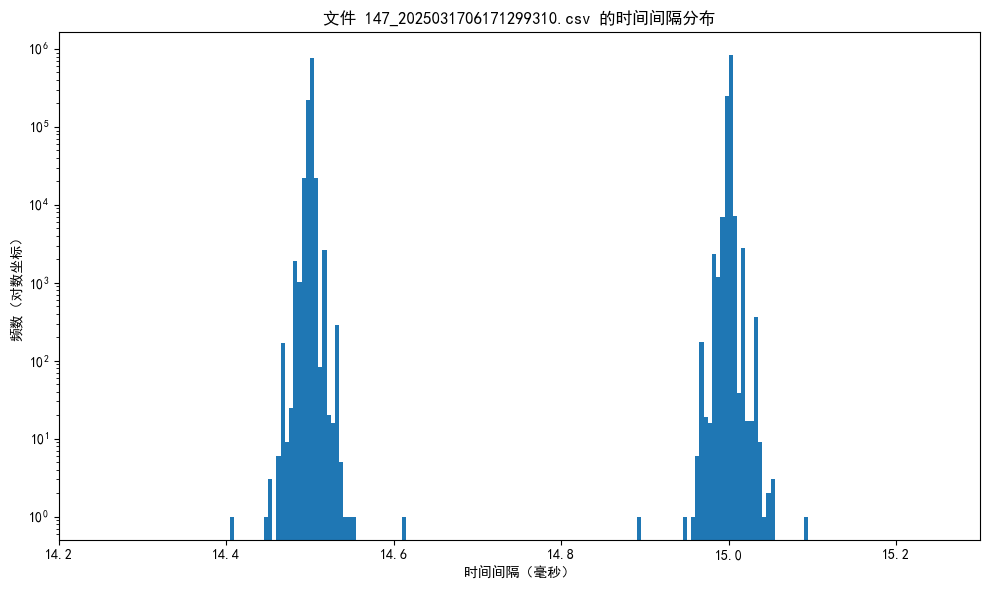

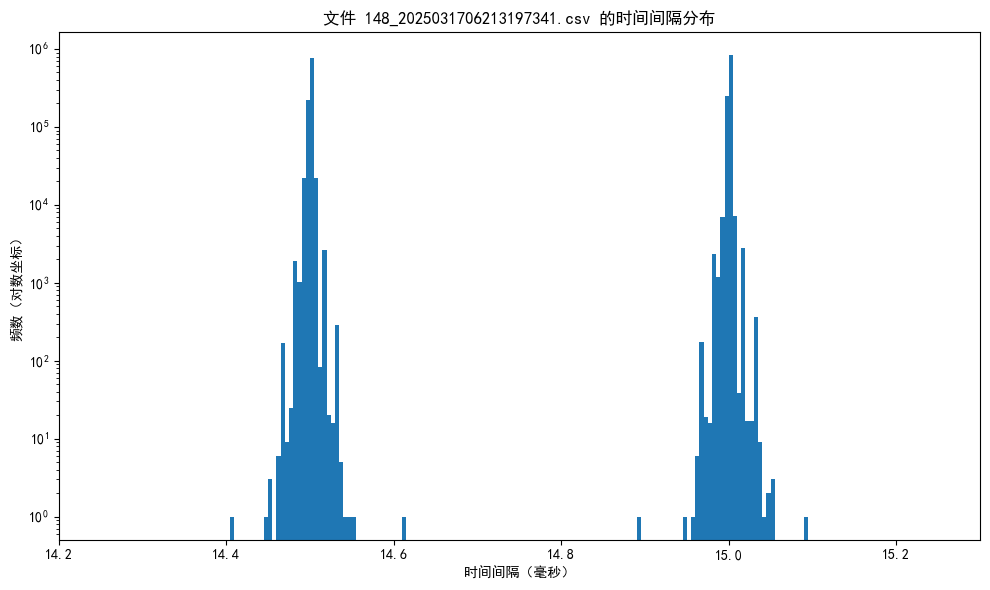

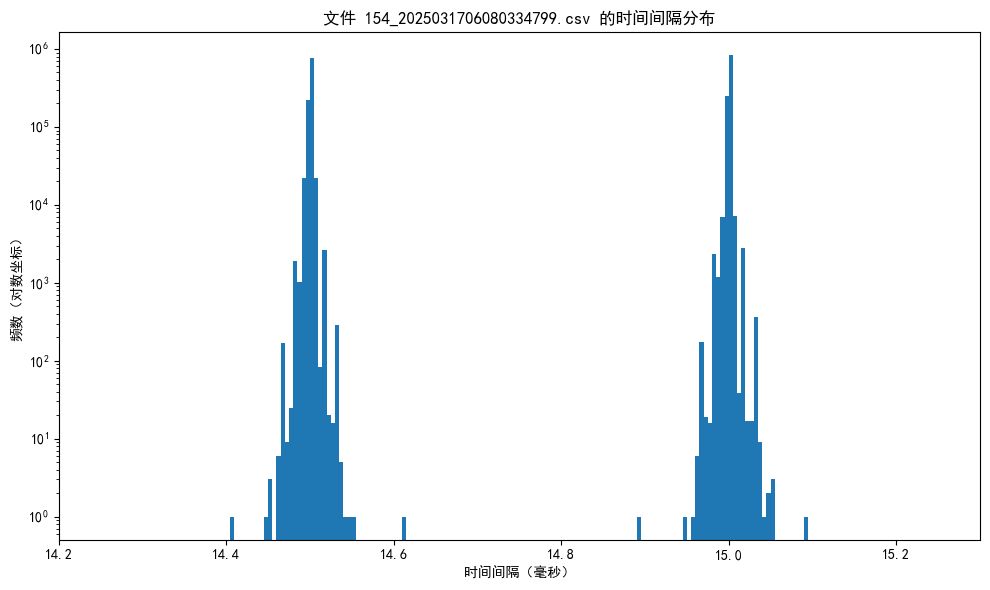

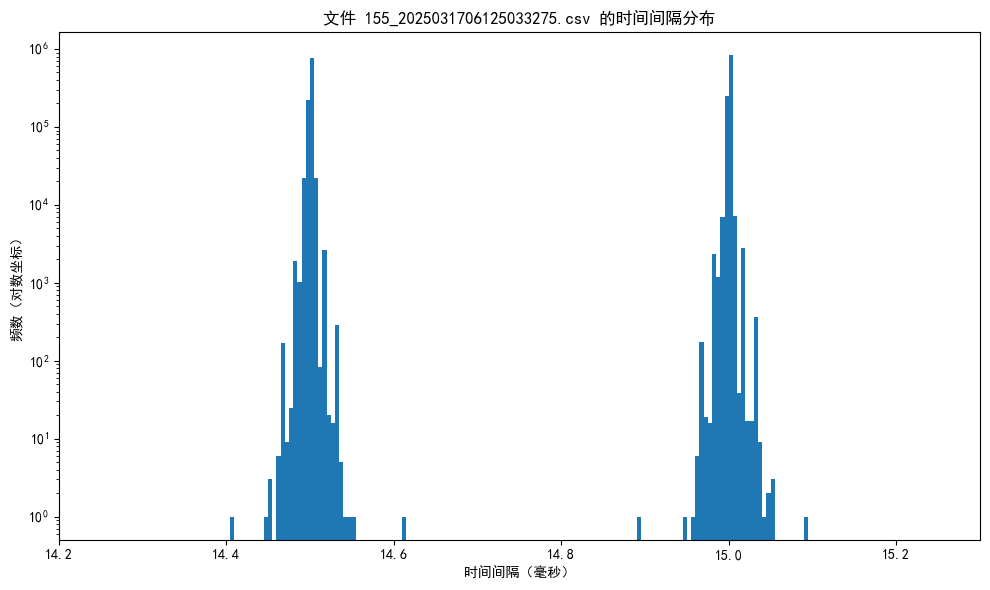

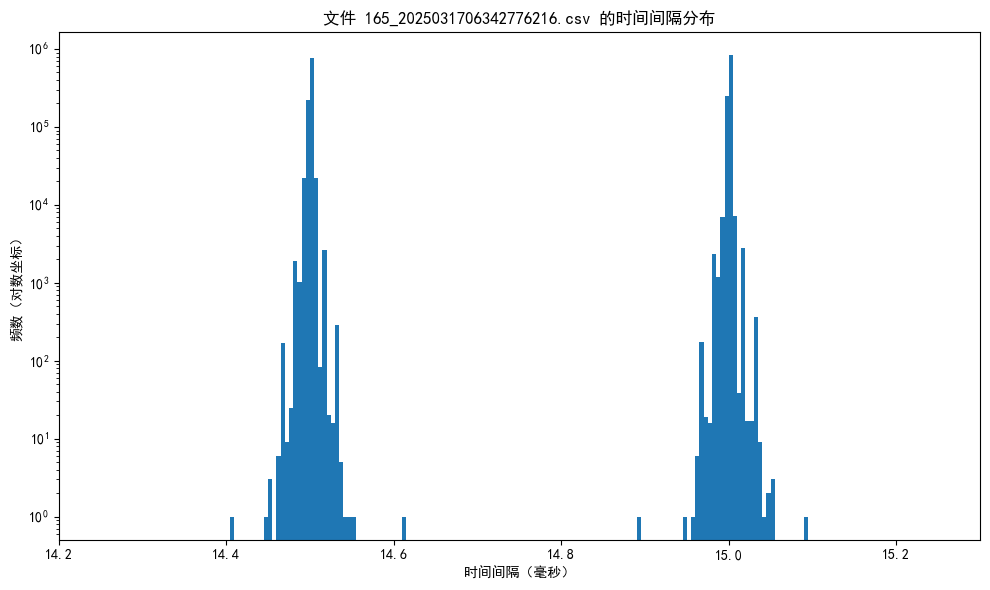

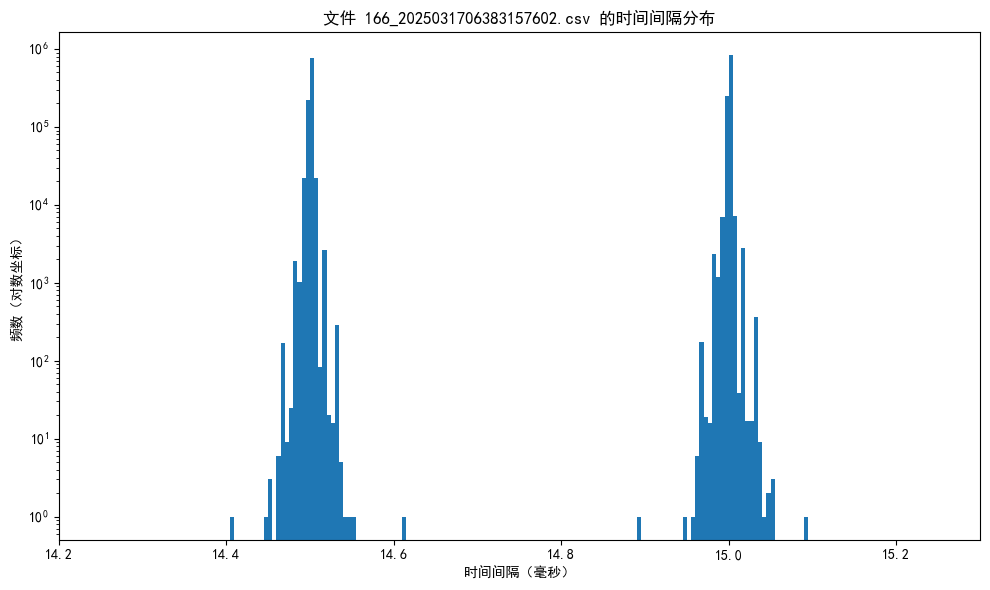

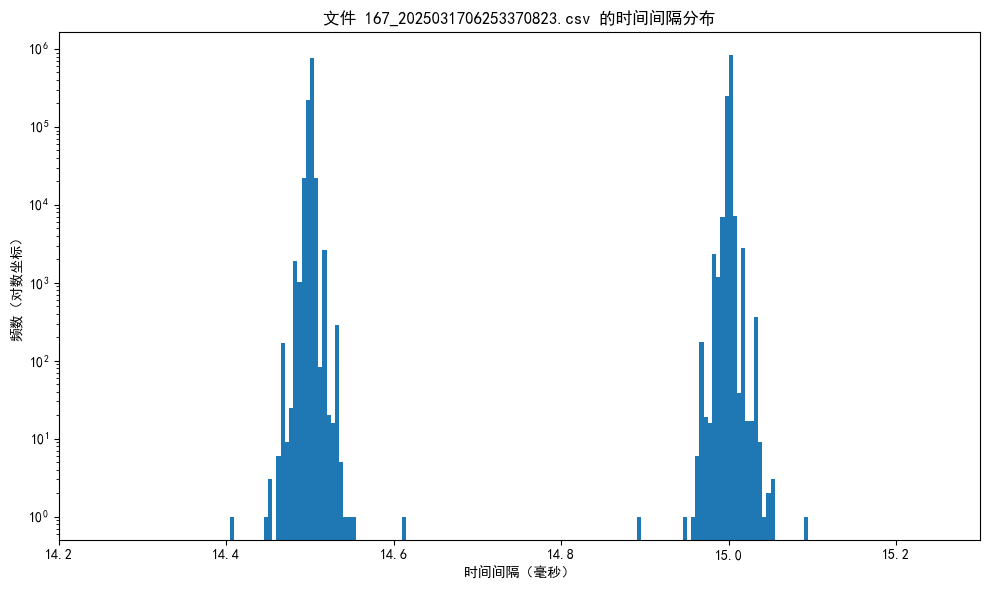

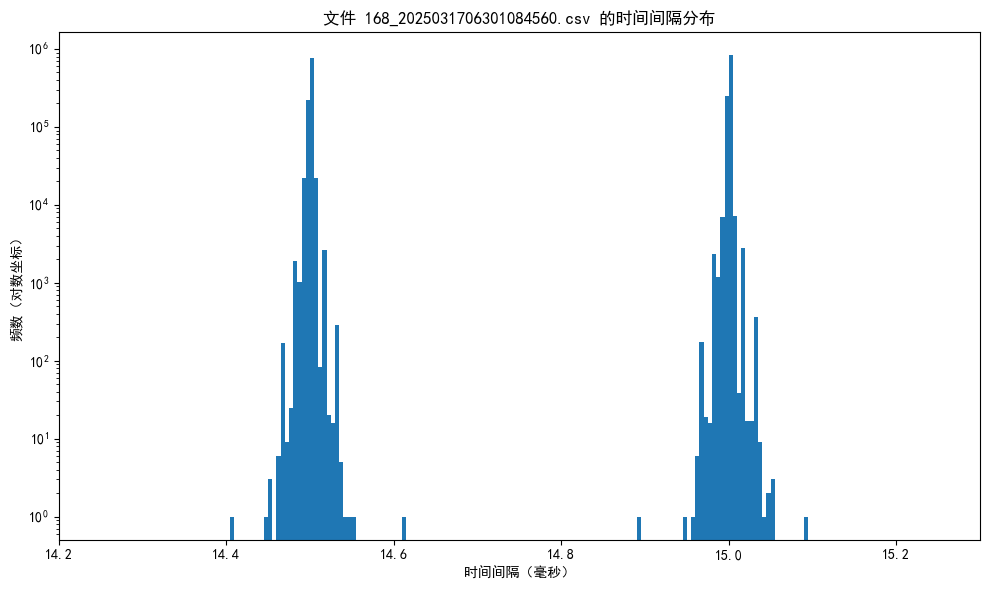

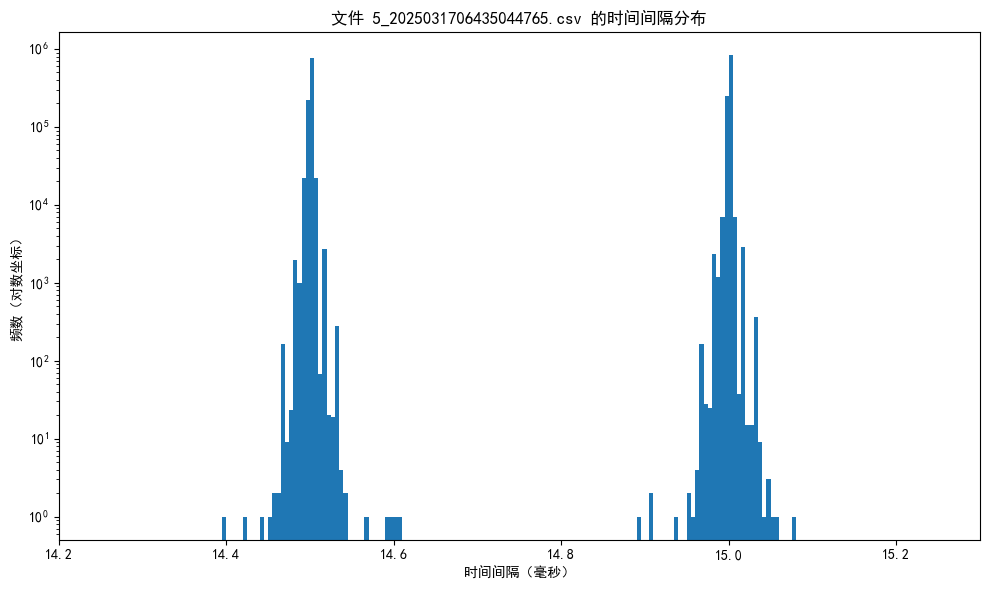

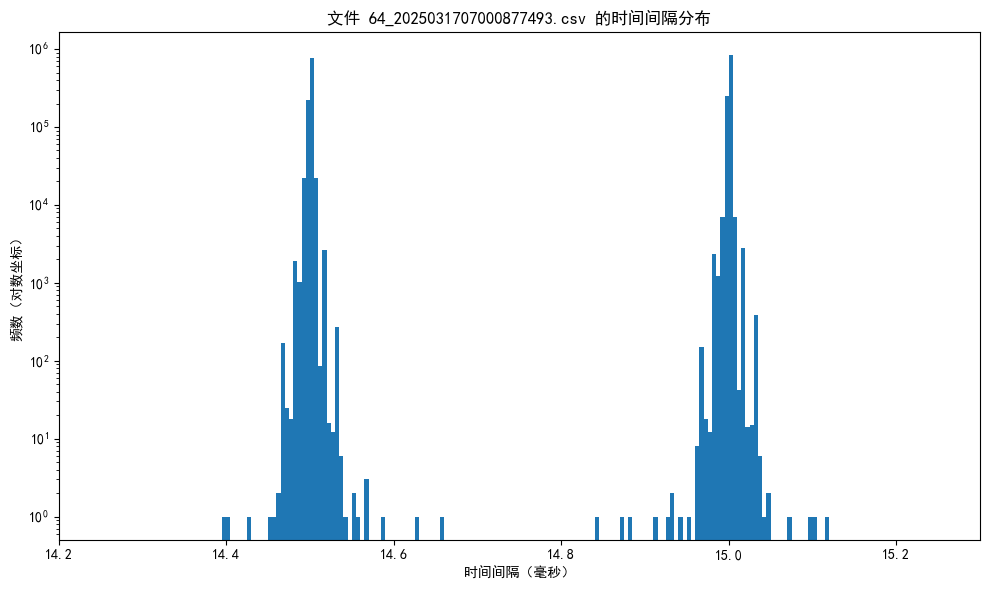

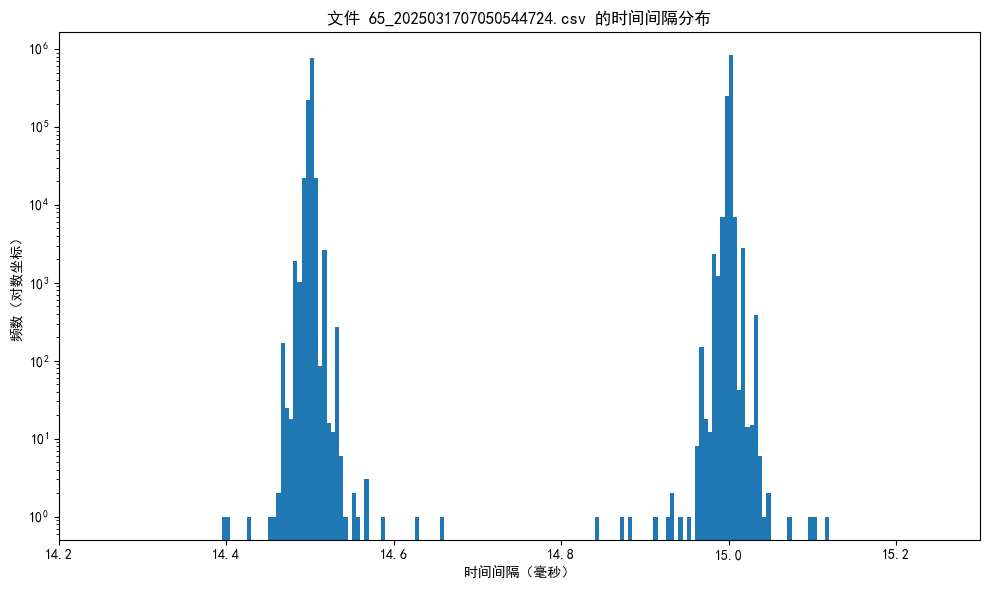

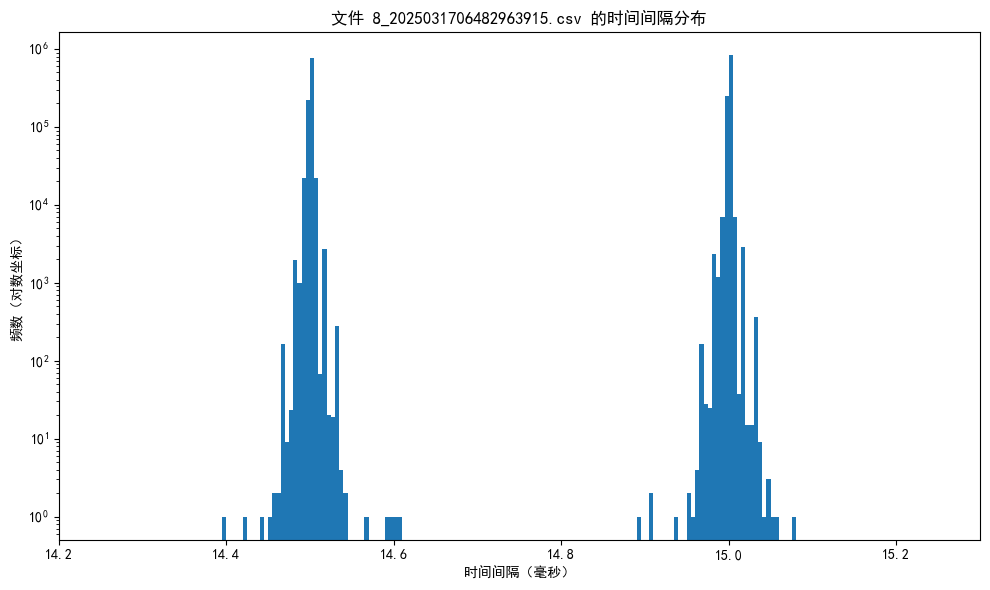

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和负号显示
plt.rcParams['font.sans-serif'] = ['Simhei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False    # 显示负号

# 对每个dataframe绘制时间间隔分布图
for file, df in dataframes.items():
    # 计算时间间隔（毫秒）
    time_diffs = df.index.to_series().diff().dt.total_seconds()
    
    # 创建新的图形
    plt.figure(figsize=(10, 6))
    
    # 绘制直方图，使用对数坐标
    plt.hist(time_diffs.dropna(), bins=200, range=(14.25, 15.25))
    plt.yscale('log')
    
    # 设置标题和标签
    plt.title(f"文件 {file} 的时间间隔分布")
    plt.xlabel("时间间隔（毫秒）")
    plt.ylabel("频数（对数坐标）")
    
    # 显示图形
    plt.tight_layout()
    plt.show()

In [16]:
import hvplot.pandas
import pandas as pd
import holoviews as hv
from bokeh.plotting import show

hv.extension('bokeh')

# 对每个dataframe绘制时间间隔分布图
for file, df in dataframes.items():
    # 计算时间间隔（毫秒）
    time_diffs = df.index.to_series().diff().dt.total_seconds()
    
    # 创建包含时间间隔的DataFrame
    diff_df = pd.DataFrame({'interval': time_diffs.dropna()})
    
    # 使用hvplot绘制直方图
    plot = diff_df.hvplot.hist(
        'interval', 
        bins=50, 
        xlim=(14.25, 15.25), 
        logy=True,
        height=400, 
        width=600,
        title=f"文件 {file} 的时间间隔分布",
        xlabel="时间间隔（毫秒）",
        ylabel="频数（对数坐标）"
    )
    
    # 显示图形
    display(plot)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)

KeyError: 'default'

:Histogram   [interval]   (Count)